### GPS Tracking Analysis ###

This jupyter notebook is designed to accept a comma-separated (csv) list of timestamped GPS latitude and longitude coordinates representing a recording of a walking or running exercise and find the fastest mile-long segment within the longer exercise. While it is taylored to work with the output from the __[Physics Toolbox Sensor Suite app](https://www.vieyrasoftware.net/)__, we have tried to make the instructions here agnostic to the method of GPS recording used.

#### The Input File Specification ####
What follows assumes that the input .csv file resembles:
```
time,Latitude,Longitude,,
08:29:14:458,37.38775891,-6.00309754,
08:29:15:460,37.38774677,-6.00311591,
08:29:16:448,37.38774284,-6.00313017,
08:29:18:468,37.38775696,-6.00314697,
08:29:19:463,37.38776887,-6.00314499,
```

The ```time``` column has timestamps for each reading. The timestamps are colon-separated values of the form hours:minutes:seconds:fraction_seconds. For example, the first timestamp occurred at 8 hours, 29 minutes and 14.458 seconds after midnight local time.

The ```Latitude``` column value is latitude from the equator (0 degrees) with northern latitudes positive and southern latitudes negative. The values to the right of the decimal point are _decimal_ fractions of a degree.

The ```Longitude``` column value is the longitude from the Prime Meridian (0 degrees) with eastern longitudes positive and western longitudes negative. The values to the right of the decimal point are _decimal_ fractions of a degree.

__Note:__ There can be other columns present in the csv file, but in order for this notebook to function properly, these columns must be present with these column header names (case-sensitive) and these value specifications.

<div class="alert alert-block alert-info">
    <b>Author:</b> Albert Schueller <br>
    <b>Affiliation:</b> <a href="https://www.whitman.edu">Whitman College</a>, Walla Walla, WA USA <br>
    <b>License:</b> GNU General Public License v3.0
</div>



In [1]:
# Libraries needed by this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Data Description: Analysis of a 4 mile run.

GPS readings during a 4 mile run. The data were measured using Physics Toolbox Sensor Suite Pro, on a OnePlus 3T phone, strapped to the runner's waist in a tight band. The app/phone combination is capable of sampling GPS at about 1Hz. The position is accurate to about 5 meters, but the accuracy varies noisily.

The goal of this notebook is to find the starts of the fastest mile-long segements within the longer run.

In [2]:
# Read the GPS data.
raw = pd.read_csv('PSM GPS Recording.csv')
# Convert 'time' column to datetime objects and re-index the dataframe using the resulting datetimes.
raw.index = pd.to_datetime(raw.time, format='%H:%M:%S:%f')
# Convert the datetimes to minutes and re-index the dataframe by the resulting minute values.
raw.index = (raw.index-raw.index[0]).total_seconds()/60

Convert sequence of lat/lon to miles using the Haversine function. __Note:__ if you want to use different units of distance, see the comment near the end of this function definition.

In [3]:
# Haversine function definition. 
def haversine(lat, lon):
    """
    Takes two columns of consecutive (lat, lon) measurements and returns an array of 
    distances between consecutive pairs using the Haversine distance function.
    """
    
    # convert degrees to np array in radians
    lat, lon = map(np.radians, map(np.array, [lat, lon]))
    
    # compute dlon/dlat
    dlat = np.diff(lat)
    dlon = np.diff(lon)
    
    # compute distances
    a = np.power(np.sin(dlat/2),2) + np.cos(lat[:-1])*np.cos(lat[1:])*np.power(np.sin(dlon/2),2)
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    
    # The constant here, 3958.7613, is the radius of the earth in miles, if you prefer different units, 
    # convert this constant into the preferred units. For example, use 6370.9929 for kilometers.
    mi = (3958.7613)* c
    return mi

In [4]:
# Compute successive distances, accumulate, and add to the raw dataframe in a new column called 'position'.

# Assign successive displacements (miles) to p.
p = haversine(raw.Latitude,raw.Longitude)
# Accumulate the successive displacement to generate position.
p = np.cumsum(p)
# Insert a zero at the front of the list since we assume we start at position 0.
p = np.insert(p,0,0)
# Insert the position array into the dataframe under the column header 'position'.
raw['position']=p.reshape(len(p),1)
# Show the data frame now, confirm the changes make sense. Note: the two unnamed columns are artifacts of the app.
# We should see the new time index followed by the original 3 columns, 2 specious columns, and the new position column.
raw.head()

,time,Latitude,Longitude,Unnamed: 3,Unnamed: 4,position
time,,,,,,
0.000000,08:29:14:458,37.387759,-6.003098,NaN,NaN,0.000000
0.016700,08:29:15:460,37.387747,-6.003116,NaN,NaN,0.001312
0.033167,08:29:16:448,37.387743,-6.003130,NaN,NaN,0.002140
0.066833,08:29:18:468,37.387757,-6.003147,NaN,NaN,0.003483
0.083417,08:29:19:463,37.387769,-6.003145,NaN,NaN,0.004313


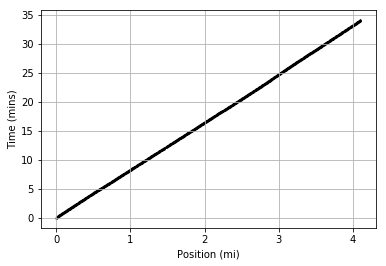

In [5]:
# Plot the time vs. position values.
plt.grid()
plt.xlabel("Position (mi)")
plt.ylabel("Time (mins)")
plt.scatter(raw['position'],raw.index,s=1,color='black')
plt.show()

In [6]:
# Compute the elapsed time of every interval of length L inside the longer recording.

# Length of interval (miles)
L = 1

et = []
k = 0
for i in range(len(raw.position-1)):
    for j in range(k,len(raw.position)):
        if raw.position.iloc[j]-raw.position.iloc[i]>=L:
            et.append(raw.index[j]-raw.index[i])
            k = j
            break
et = np.array(et)

### Regression to Find Fastest Mile ###
Here we use a 10th order polynomial regression and approximate global extrema using the polynomial regression.

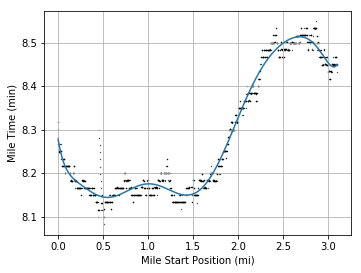

Fastest mile:
	 Pace 8 min 8 sec per mile.
	 Started 0.55 mi into the run.

Slowest mile:
	 Pace 8 min 30 sec per mile.
	 Started 2.68 mi into the run.


In [7]:
# Plot the mile time vs. position.
X=np.array(raw.position.iloc[0:len(et)])
Y=et

fig, ax = plt.subplots(figsize=[5.5,4.125])
ax.grid()
ax.scatter(X,Y,color='black',s=.1)
ax.set_xlabel("Mile Start Position (mi)")
ax.set_ylabel("Mile Time (min)")

# Fit and plot a high-order polynomial to the data to approximate global max/min
poly_fit_order = 10
fit = np.polyfit(X,Y,poly_fit_order)
Y_fit = np.polyval(fit,X)
ax.plot(X,Y_fit)

# Show plot
plt.show()

# We can automate the finding of global extrema using the built in max/min function.
# Reporting strings.
pace_str = "Pace {0} min {1} sec per mile."
loc_str = "Started {:.2f} mi into the run."

# Find and print indices of fastest and slowest miles in the fitted polynomial.
g_min_ind = Y_fit.argmin()
g_max_ind = Y_fit.argmax()

# Convert to minutes and seconds for reporting purposes
g_min_minutes = int(Y_fit[g_min_ind])
g_min_seconds = int((Y_fit[g_min_ind]-g_min_minutes)*60)
g_max_minutes = int(Y_fit[g_max_ind])
g_max_seconds = int((Y_fit[g_max_ind]-g_max_minutes)*60)

# Report fastest and slowest mile paces and locations.
print("Fastest mile:")
print('\t', pace_str.format(g_min_minutes, g_min_seconds))
print('\t', loc_str.format(X[g_min_ind]))

print("\nSlowest mile:")
print('\t', pace_str.format(g_max_minutes, g_max_seconds))
print('\t', loc_str.format(X[g_max_ind]))

### Smoothing to Find Fastest Mile ###
Here we use the lowess smoothing algorithm and approximate global extrema using the smoothed data.

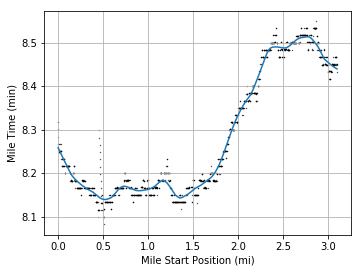

Fastest mile:
	 Pace 8 min 8 sec per mile.
	 Started 0.52 mi into the run.

Slowest mile:
	 Pace 8 min 30 sec per mile.
	 Started 2.77 mi into the run.


In [8]:
# The lowess smoothing algorithm
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.signal import argrelextrema
X=np.array(raw.position.iloc[0:len(et)])
Y=et

fig, ax = plt.subplots(figsize=[5.5,4.125])
ax.grid()
ax.scatter(X,Y,color='black',s=.1)
ax.set_xlabel("Mile Start Position (mi)")
ax.set_ylabel("Mile Time (min)")

# Smooth using lowess algorithm, this algorithm smooths by fitting local linear regressions 
# using a collection of nearby points, the frac parameter, between 0 and 1, says how many 
# surrounding points to use, for example frac=0.05 says to use the 5% of the data closest
# to the point of interest. The larger frac, the more smoothing.
smoothed = lowess(Y, X, is_sorted=True, frac=0.1, it=0)
Y_smoothed = smoothed[:,1]
ax.plot(X,Y_smoothed)

# Show the plot
plt.show()

# We can automate the finding of global extrema using the built in max/min function.
# Reporting strings.
pace_str = "Pace {0} min {1} sec per mile."
loc_str = "Started {:.2f} mi into the run."

# Find and print indices of fastest and slowest miles.
g_min_ind = Y_smoothed.argmin()
g_max_ind = Y_smoothed.argmax()

# Convert to minutes and seconds for reporting purposes
g_min_minutes = int(Y_smoothed[g_min_ind])
g_min_seconds = int((Y_smoothed[g_min_ind]-g_min_minutes)*60)
g_max_minutes = int(Y_smoothed[g_max_ind])
g_max_seconds = int((Y_smoothed[g_max_ind]-g_max_minutes)*60)

# Report fastest and slowest mile paces and locations.
print("Fastest mile:")
print('\t', pace_str.format(g_min_minutes, g_min_seconds))
print('\t', loc_str.format(X[g_min_ind]))

print("\nSlowest mile:")
print('\t', pace_str.format(g_max_minutes, g_max_seconds))
print('\t', loc_str.format(X[g_max_ind]))

